In [2]:
import random
import numpy as np
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import animation
import copy


In [3]:
# Helper functions
def rotate_list(l, n):
    return l[n:] + l[:n]

In [4]:
class Marker:
        def __init__(self):
            self.active = True
            self.count = 0

class KacModel():
    def __init__(self, n, m, s):
        self.N = n # number of balls
        self.M = m # number of markers
        self.S = s # number of internal states for makers
        self.time = 0
        self.init_ring()
        self.init_markers()
    
    def init_ring(self, n=None):
        if (n):
            self.N = n
        self.ring = [random.randint(0,1) for _ in range(self.N)]

    def init_markers(self, m=None):
        if (m):
            self.M = m
        marker_positions = random.sample(range(self.N), self.M)
        min_pos = min(marker_positions)
        marker_positions = [x - min_pos % self.N for x in marker_positions] # WLOG start markers at 0
        self.markers = {x: Marker() for x in random.sample(range(self.N), self.M)}

    def markers_at_inital_val(self):
        for marker in self.markers.values():
            if not (marker.active and marker.count == 0):
                return False
        return True

    def step_time(self):
        self.time += 1
        # first increase marker count
        for pos,marker in self.markers.items():
            if self.ring[pos] and self.S > 0: # increase marker count if on white ball, and only if marker has nonzero internal states
                marker.count += 1
            # switch ball states
            if marker.active:
                self.ring[pos] = int(not bool(int(self.ring[pos])))
        # switch marker states
        if self.S > 0:
            for marker in self.markers.values():
                if marker.count == self.S:
                    marker.count = 0
                    marker.active = not marker.active
        # rotate
        self.ring = rotate_list(self.ring, 1)

    def state_val(self):
        return int("".join(str(x) for x in self.ring), 2)

    def state_str(self):
        val = "{num:0{width}}".format(num=self.state_val(), width=int(np.log10(2**self.N))+1)
        d = int(np.log10(self.S)) + 1 if self.S > 0 else 1
        for marker in self.markers.values():
            val += str(int(marker.active)) + "{num:0{width}}".format(num=marker.count, width=d)
        return val

    def copy(self):
        model = KacModel(self.N, self.M, self.S)
        model.ring = list(self.ring)
        model.markers = {}
        for pos in self.markers:
            model.markers[pos] = Marker()
            model.markers[pos].active = self.markers[pos].active
            model.markers[pos].count = self.markers[pos].count
        return model

    def __str__(self):
        ring = " ".join(str(x) for x in self.ring)
        ring += '\t' + str(self.state_val())
        markers = [" "] * self.N * 2
        counts = [" "] * self.N * 2
        for pos in self.markers:
            markers[pos * 2] = '^' if self.markers[pos].active else "."
            counts[pos * 2] = str(self.markers[pos].count)
        return ring + '\n' + "".join(markers) + '\n' + "".join(counts)


In [5]:
def find_period(model, verbose=False):
    vals = [model.state_str()]
    if verbose:
        print(model.state_str())
    model.step_time()
    while not (model.state_str() in vals):
        if verbose:
            print(model.state_str())
        vals.append(model.state_str())
        model.step_time()
    loop_start = vals.index(model.state_str())
    return len(vals) - loop_start, loop_start

In [15]:
n = 8
m = 3
s = 4

periods = []

for i in range(2**n):
    model = KacModel(n, m, s)
    model.ring = [int(c) for c in "{0:b}".format(i)]
    model.markers = {0: Marker()}
    p, s = find_period(model, False)
    periods.append(p)

uniques = set(periods)
for p in sorted(list(uniques)):
    print("{}: {}".format(p, periods.count(p)))



1: 3
2: 3
4: 2
6: 3
8: 8
10: 15
12: 30
14: 63
16: 128
115: 1


In [154]:
model = KacModel(10, 2, 0)
model.ring = [1,1,1,1,0,0,0,0,1,1]
model.markers = {3: Marker(), 9: Marker()}

print(model)

1 1 1 1 0 0 0 0 1 1	963
      ^           ^ 
      0           0 


In [155]:
def plot_model(model, fig, ax, period=None):
    r = 0.8 * np.pi / model.N
    ax.axis('off')
    ax.set_aspect(1)    
    ax.set_xlim(-1 - 1.1*r, 1 + 1.1*r)
    ax.set_ylim(-1 - 1.1*r, 1 + 1.1*r)
    # time / state / period
    ax.text(-1.2, 1.2, "Step: " + str(model.time))
    #ax.text(0.9, -1.1, model.state_str())
    if period:
        ax.text(0.9, 1.2, "Period: " + str(period))
    # circles
    for i in range(model.N):
        theta = i * 2 * np.pi / model.N
        circ = plt.Circle((np.cos(theta), np.sin(theta)), r, color='black', fill=bool(model.ring[i]))
        ax.add_patch(circ)
    # Arrows
    for pos,marker in model.markers.items():
        theta = pos * 2 * np.pi / model.N
        text = 1 - 2.2*r
        base = 1 - 2*r
        length = 2*r/3
        width = 0.02
        ax.arrow(base*np.cos(theta), base*np.sin(theta), length*np.cos(theta), length*np.sin(theta), width=width, length_includes_head=True, color='black', fill=marker.active)
        if model.S > 0:
            ax.text(text*np.cos(theta), text*np.sin(theta), str(marker.count))

In [158]:
def animate_model(model, steps, filename, period=None, cycle_start=None):
    fig, ax = plt.subplots()

    plot_model(model, fig, ax, period)

    def init():
        ax.cla()
        print(model.time)
        plot_model(model, fig, ax, period)

    def animate(i):
        global model
        ax.cla()
        plot_model(model, fig, ax, period)
        if cycle_start and i == cycle_start:
            ax.text(0,0,"Cycle Start")
        model.step_time()

    anim = animation.FuncAnimation(fig=fig, func=animate, init_func=init, frames=steps+1, repeat=False)
    anim.save(filename, fps=1, extra_args=['-vcodec', 'libx264'])

0


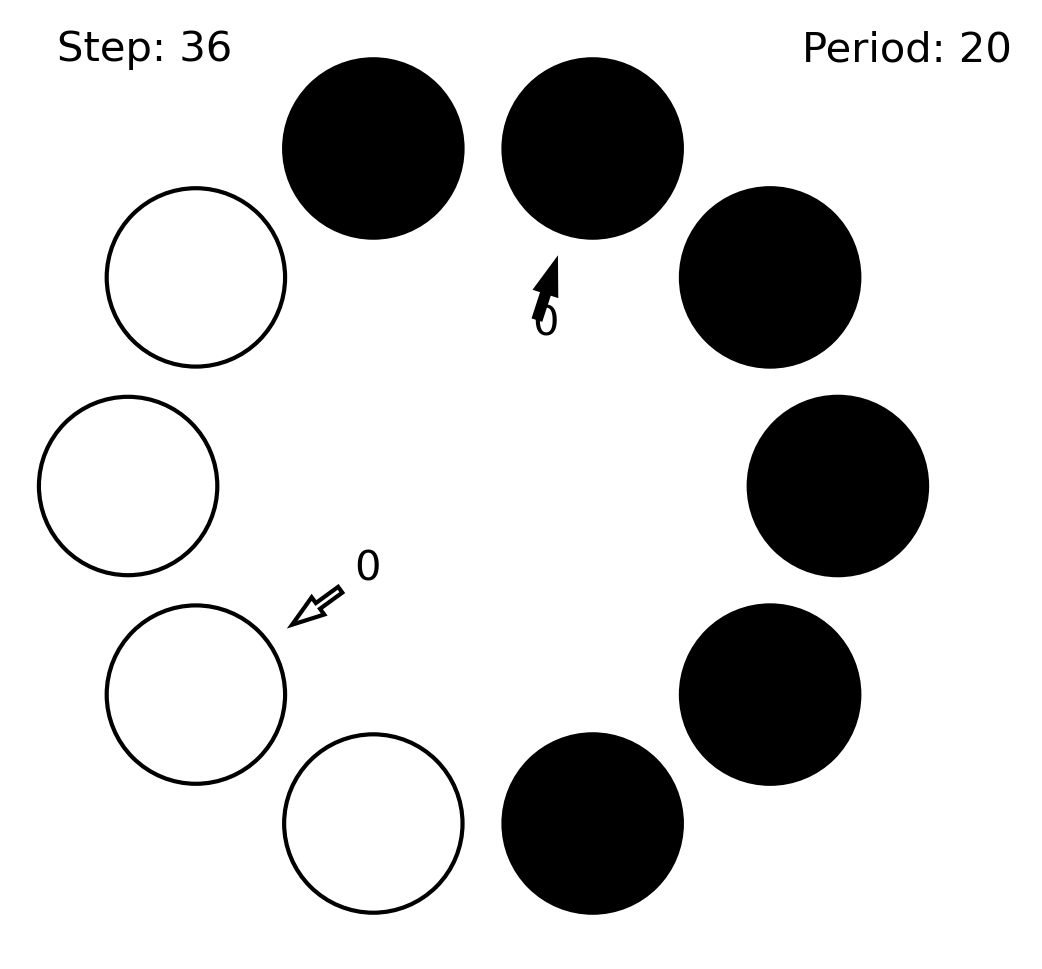

In [160]:
n = 10
m = 2
s = 5

model = KacModel(n, m, s)
model_cpy = model.copy()
p, cycle_start = find_period(model_cpy)

animate_model(model, p+cycle_start, "unconverted/{}_{}_{}.mp4".format(n, m, s), p, cycle_start)

In [19]:
foo = random.sample(range(100), 10)
minval = min(foo)
bar = [x - minval % 100 for x in foo]
print(foo, bar)

[37, 14, 1, 27, 24, 93, 48, 75, 45, 87] [36, 13, 0, 26, 23, 92, 47, 74, 44, 86]
